In [1]:
pip install tsplib95

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import tsplib95
from tqdm import tqdm

# Implementacja NSGA-II

In [3]:
class NSGA_II:
    def __init__(self, chromosome_length, population_size, objectives_number,
                 initial_population, initial_objective_values):
        self.chromosome_length = chromosome_length
        self.population_size = population_size
        self.objectives_number = objectives_number
        if type(initial_population) is not np.ndarray:
            raise ValueError("initial population must be a numpy array")
        if initial_population.shape != (self.population_size, self.chromosome_length):
            raise ValueError("initial population must be of shape (population_size, chromosome_length)")
        self.current_population = initial_population
        if type(initial_objective_values) is not np.ndarray:
            raise ValueError("initial objective values must be a numpy array")
        if initial_objective_values.shape != (self.population_size, self.objectives_number):
            raise ValueError("initial population values must be of shape (population_size, objectives_number)")
        self.current_objective_values = initial_objective_values
        self.current_pareto_frontier = np.empty(self.population_size)
        self.current_crowding_distances = np.empty(self.population_size)
        self.replace_population(None, None)


    def get_population(self):
        return self.current_population


    def non_dominated_sort(self, objective_values):

        def dominates(vals1, vals2):
            return np.all(vals1 <= vals2) and np.any(vals1 < vals2)

        size = objective_values.shape[0]
        pareto_frontier = np.empty(size, dtype=int)
        current_frontier_number = 1
        current_frontier_members = []
        # number of solutions dominating p
        dominating_count = np.zeros(size, dtype=int)
        # set of solutions dominated by p
        dominated = [None] * size 

        for p in range(size):
            dominated[p] = []
            for q in range(size):
                if dominates(objective_values[p], objective_values[q]):
                    dominated[p].append(q)
                elif dominates(objective_values[q], objective_values[p]):
                    dominating_count[p] += 1
            if dominating_count[p] == 0:
                pareto_frontier[p] = current_frontier_number
                current_frontier_members.append(p)

        while current_frontier_members != []:
            current_frontier_number += 1
            new_frontier_members = []
            for p in current_frontier_members:
                for q in dominated[p]:
                    dominating_count[q] -= 1
                    if dominating_count[q] == 0:
                        pareto_frontier[q] = current_frontier_number
                        new_frontier_members.append(q)
            current_frontier_members = new_frontier_members
        
        return pareto_frontier


    def assign_crowding_distance(self, objective_values):
        size = objective_values.shape[0]
        distance = np.zeros(size)
        for current_objective in range(self.objectives_number):
            current_objective_values = objective_values[:, current_objective]
            sorted_indices = np.argsort(current_objective_values)
            current_objective_values_diff = current_objective_values[sorted_indices[-1]] - current_objective_values[sorted_indices[0]]
            if current_objective_values_diff == 0:
                continue
            distance[sorted_indices[0]], distance[sorted_indices[-1]] = np.inf, np.inf
            for i in range(1, size-1):
                distance[sorted_indices[i]] += ((current_objective_values[sorted_indices[i+1]] - current_objective_values[sorted_indices[i-1]]) /
                                                current_objective_values_diff)
        return distance


    def generate_children(self, crossover_operator, mutation_operator,
                          crossover_probability = 0.95, mutation_probability = 0.25,
                          number_of_offspring = None):

        def compare(p, q):
            if self.current_pareto_frontier[p] == self.current_pareto_frontier[q]:
                return self.current_crowding_distances[p] > self.current_crowding_distances[q]
            return self.current_pareto_frontier[p] > self.current_pareto_frontier[q]

        if number_of_offspring is None:
            number_of_offspring = self.population_size

        # selecting parent indices by the binary tournament method
        parent_indices = np.empty(number_of_offspring, dtype=np.int64)
        for i in range(number_of_offspring):
            candidates = np.random.choice(self.population_size, 2, False)
            if compare(candidates[0], candidates[1]):
                parent_indices[i] = candidates[0]
            else:
                parent_indices[i] = candidates[1]

        # creating children population
        children_population = np.empty((number_of_offspring, self.chromosome_length))
        for i in range(number_of_offspring//2):
            if np.random.random() < crossover_probability:
                children_population[2*i], children_population[2*i+1] = crossover_operator(self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy())
            else:
                children_population[2*i], children_population[2*i+1] = self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1] = self.current_population[parent_indices[-1]]

        # mutating children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i] = mutation_operator(children_population[i])

        return children_population


    def replace_population(self, children_population, children_objective_values):

        if(children_population is None and children_objective_values is None):
            combined_population = self.current_population
            combined_objective_values = self.current_objective_values
        else:
            combined_population = np.vstack((self.current_population, children_population))
            combined_objective_values = np.vstack((self.current_objective_values, children_objective_values))

        combined_pareto_frontier = self.non_dominated_sort(combined_objective_values)

        positions = np.argsort(combined_pareto_frontier)

        combined_population = combined_population[positions]
        combined_objective_values = combined_objective_values[positions]
        combined_pareto_frontier = combined_pareto_frontier[positions]

        # assign crowding distance and select subset of last frontier
        found_population_size = 0
        current_frontier_number = 1
        current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                    np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
        current_frontier_size = current_frontier_rb - current_frontier_lb
        while found_population_size + current_frontier_size < self.population_size:
            found_population_size += current_frontier_size
            current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
            self.current_crowding_distances[current_frontier_lb : current_frontier_rb] = current_frontier_distances
            current_frontier_number += 1
            current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                        np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
            current_frontier_size = current_frontier_rb - current_frontier_lb

        current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
        last_frontier_taken_indices = np.argsort(current_frontier_distances)[::-1][:self.population_size - found_population_size]

        combined_population[current_frontier_lb : self.population_size] = combined_population[last_frontier_taken_indices]
        combined_objective_values[current_frontier_lb : self.population_size] = combined_objective_values[last_frontier_taken_indices]
        self.current_crowding_distances[current_frontier_lb : self.population_size] = current_frontier_distances[last_frontier_taken_indices]

        self.current_population = combined_population[:self.population_size]
        self.current_objective_values = combined_objective_values[:self.population_size]
        self.current_pareto_frontier = combined_pareto_frontier[:self.population_size]

        return True

## Przykładowy problem

In [83]:
def middle_crossover(p, q):
    return ((2/3) * p + (1/3) * q), ((1/3) * p + (2/3) * q)
def random_noise_mutation(p):
    return p + np.random.normal()

(array([12., 11., 12., 10.,  7.,  8.,  8., 12., 10., 10.]),
 array([2.82857274e-04, 2.00253745e-01, 4.00224633e-01, 6.00195521e-01,
        8.00166409e-01, 1.00013730e+00, 1.20010819e+00, 1.40007907e+00,
        1.60004996e+00, 1.80002085e+00, 1.99999174e+00]),
 <a list of 10 Patch objects>)

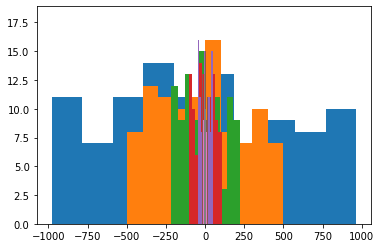

In [91]:
# pareto frontier in range (0, 2)
f1 = lambda x: x**2
f2 = lambda x: (x-2)**2

pop_size = 100
init = np.random.uniform(-1000, 1000, pop_size).reshape(-1, 1)
init_vals = np.hstack((f1(init), f2(init)))

nsga_ii = NSGA_II(1, pop_size, 2, init, init_vals)

for t in range(100):
    plt.hist(nsga_ii.get_population())
    children = nsga_ii.generate_children(middle_crossover, random_noise_mutation)
    children_vals = np.hstack((f1(children), f2(children)))
    nsga_ii.replace_population(children, children_vals)

plt.hist(nsga_ii.get_population())

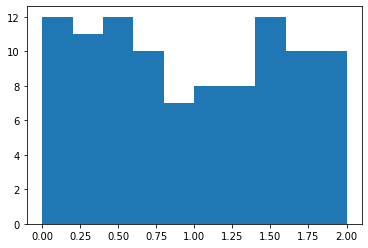

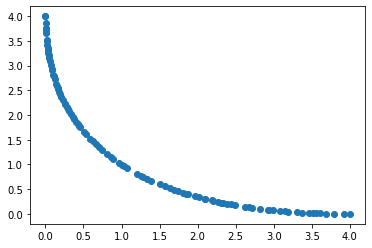

In [92]:
pop = nsga_ii.get_population()
pop_vals = np.hstack((f1(pop), f2(pop)))
plt.figure()
plt.hist(pop)
plt.figure()
plt.scatter(pop_vals[:, 0], pop_vals[:, 1])

# MOTSP

## Operatory krzyżowania

In [42]:
def PMX(ind1, ind2):

    def getIdx(val, arr):
        result = np.where(arr == val)
        return result[0][0]

    a = np.random.choice(len(ind1), 2, False)
    i, j = a.min(), a.max()+1
    swath1 = ind1[i:j]
    swath2 = ind2[i:j]

    map = {}
    for chrom in swath1:
        if chrom in swath2:
            continue
        else:
            paired = chrom
            while(paired in swath1):
                paired = swath2[getIdx(paired, swath1)]
            map[paired] = chrom
            map[chrom] = paired
    oldInd1, oldInd2 = ind1, ind2

    for idx in range(len(ind1)):
        chrom = ind1[idx]
        if (chrom in swath2) and (chrom in map):
            ind1[idx] = map[chrom]
    ind1[i:j] = swath2

    for idx in range(len(ind1)):
        chrom = ind2[idx]
        if (chrom in swath1) and (chrom in map):
            ind2[idx] = map[chrom]
    ind2[i:j] = swath1

    return ind1, ind2


def OX(ind1, ind2):
    a = np.random.choice(len(ind1), 2, False)
    i, j = a.min(), a.max()+1
    swath1 = ind1[i:j]
    swath2 = ind2[i:j]
    
    rest2 = np.array([chrom for chrom in ind1 if chrom not in swath2])
    rest1 = np.array([chrom for chrom in ind2 if chrom not in swath1])
    
    ind1 = np.concatenate((rest2[0:i], swath2, rest2[i:]))
    ind2 = np.concatenate((rest1[0:i], swath1, rest1[i:]))
    
    return ind1, ind2


def CX(ind1, ind2):

    def getIdx(val, arr):
        result = np.where(arr == val)
        return result[0][0]
        
    def color_cycle(idx):
        while cycles[idx] == 0 :
            cycles[idx] = color
            idx = getIdx(ind2[idx], ind1)

    cycles = np.zeros(len(ind1))
    color = 1
    for idx in range(len(ind1)):
        if cycles[idx] == 0 :
            color_cycle(idx)
            color += 1

    mask = (cycles%2).astype(bool)


    child1, child2 = np.zeros(len(ind1)), np.zeros(len(ind1))
    child1[mask], child2[mask] = ind1[mask], ind2[mask]
    neg = np.logical_not
    child1[neg(mask)], child2[neg(mask)] = ind2[neg(mask)], ind1[neg(mask)]
    
    return child1, child2

## Operatory mutacji

In [43]:
def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

def element_transposition_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i], q[j] = q[j], q[i]
    return q

def insert_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q = np.concatenate((q[0:i], q[j:j+1], q[i:j], q[j+1:]))
    return q

## Funkcja celu

In [16]:
def tsp_objective_function(perm, objectives_number, *problems):
    result = np.zeros(objectives_number)
    for pos in range(perm.shape[0]):
        for obj in range(objectives_number):
            result[obj] += problems[obj].get_weight(perm[pos-1], perm[pos])
    return result

## Rysowanie wykresu

In [71]:
def plot_results(solutions, result_vals):
    plt.figure(figsize=(12,12))
    plt.scatter(solutions[:, 0], solutions[:, 1], c='r')
    plt.scatter(result_vals[:, 0], result_vals[:, 1], c='b')

## Przykładowy problem MOTSP

In [28]:
problemA = tsplib95.load("euclidA100.tsp")
problemB = tsplib95.load("euclidB100.tsp")

In [36]:
solutionsAB = np.loadtxt('best.euclidAB100.tsp', dtype=int)

In [21]:
tsp_objective_function(np.random.permutation(100)+1, 2, problemA, problemB)

array([162031., 170699.])

100%|██████████| 500/500 [16:23<00:00,  1.97s/it]


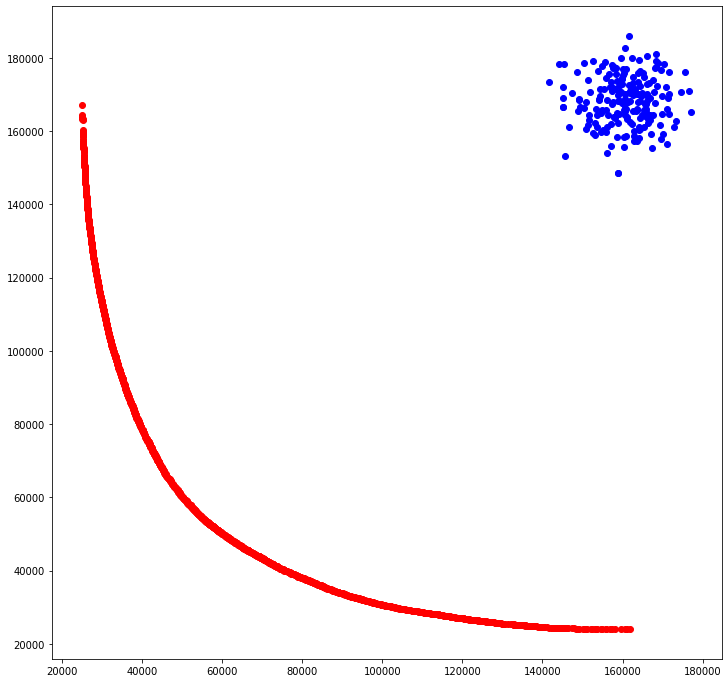

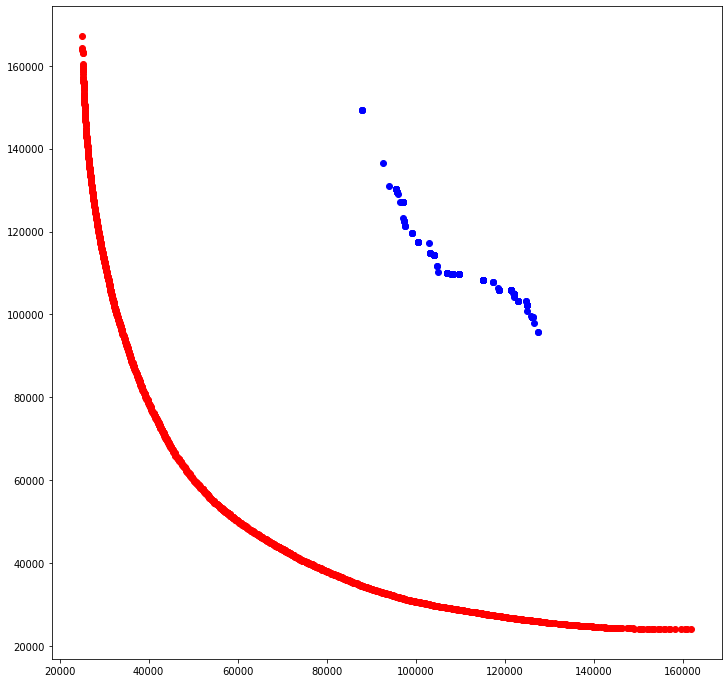

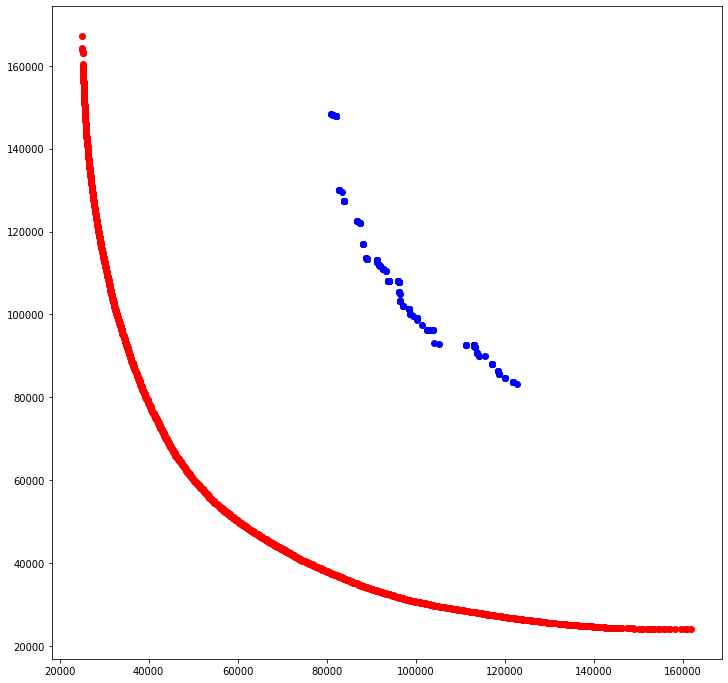

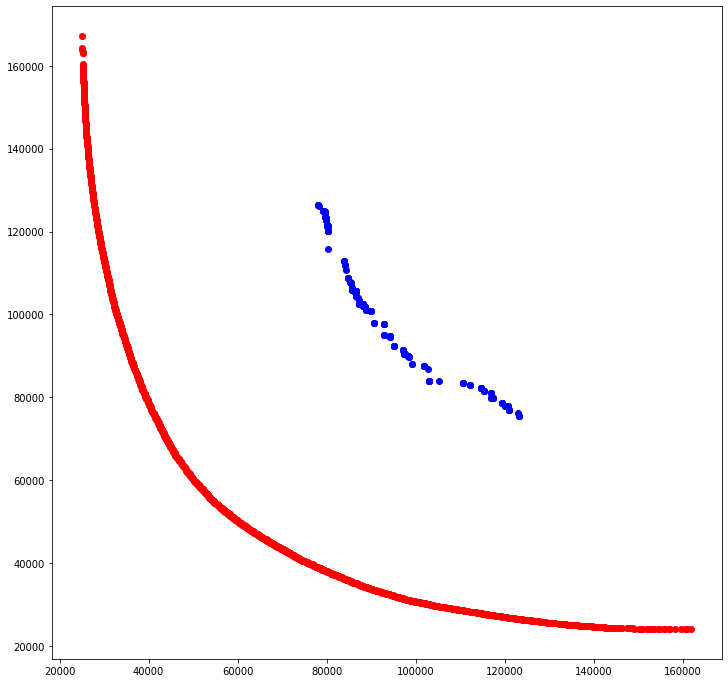

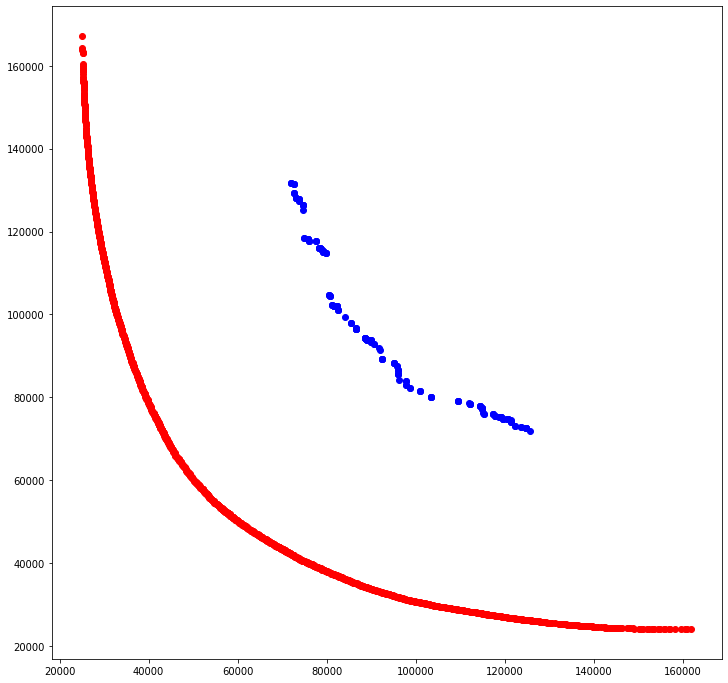

In [82]:
chrom_len = 100
pop_size = 200
obj_num = 2
n_iters = 500

init_pop = np.empty((pop_size, chrom_len))
init_vals = np.empty((pop_size, obj_num))

for i in range(pop_size):
    ind = np.random.permutation(chrom_len) + 1
    init_pop[i] = ind
    init_vals[i] = tsp_objective_function(ind, obj_num, problemA, problemB)

nsga_ii = NSGA_II(chrom_len, pop_size, obj_num, init_pop, init_vals)

for t in tqdm(range(n_iters)):

    if(np.mod(t, 100) == 0):
        result_pop = nsga_ii.get_population()
        result_vals = np.empty((result_pop.shape[0], obj_num))
        for i in range(result_pop.shape[0]):
            result_vals[i] = tsp_objective_function(result_pop[i], obj_num, problemA, problemB)
        plot_results(solutionsAB, result_vals)

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation)
    children_vals = np.empty((children.shape[0], obj_num))
    for i in range(children.shape[0]):
        children_vals[i] = tsp_objective_function(children[i], obj_num, problemA, problemB)
    nsga_ii.replace_population(children, children_vals)